In [1]:
import numpy as np
import random
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.stats import linregress
import pandas as pd

In [2]:
def generate_ground_state_set_GHZ(max_hd, degeneracy):
    """Generate a set of ground states with a guaranteed max_hd and at least one GHZ pairing (0 and max_hd)"""
    gs_set = {0, (2**max_hd) - 1}
    while len(gs_set) < degeneracy:
        gs_set.add(random.getrandbits(max_hd))
    return list(gs_set)

def generate_ground_state_set_random(max_hd, degeneracy, N):
    """Generate a set of ground states with specified degeneracy."""
    gs_set = {0}
    
    # Generate the first state by flipping the first max_hd bits
    next_gs = 0
    for i in range(max_hd):
        next_gs ^= (1 << i)  # Flip the ith bit
    gs_set.add(next_gs)
    last_gs = next_gs

    # Generate the remaining states
    while len(gs_set) < degeneracy:
        next_gs = last_gs
        for _ in range(max_hd):
            i = random.randint(0, N - 1)
            next_gs ^= (1 << i)  # Flip the ith bit
        gs_set.add(next_gs)
        last_gs = next_gs

    return list(gs_set)

def calculate_hamming_distances(gs_array, degeneracy):
    """Calculate Hamming distances and spins involved from the ground state array."""
    
    hd_list = []
    hd_matrix = np.zeros((degeneracy, degeneracy))
    spins_involved = 0
    


    for gs_i in range(degeneracy):
        for gs_j in range(gs_i + 1, degeneracy):
            binary_diff = gs_array[gs_i] ^ gs_array[gs_j]
            h_d = binary_diff.bit_count()
            hd_list.append(h_d)
            hd_matrix[gs_i][gs_j] = hd_matrix[gs_j][gs_i] = h_d
            spins_involved |= binary_diff

    return hd_list, hd_matrix, spins_involved.bit_count()

def compute_overlap_distribution(hd_list, N, degeneracy):
    """Compute the overlap distribution and related statistics."""
    overlap_dist = np.zeros(N + 1)
    overlap_dist[-1] = 1 / degeneracy

    for hd in hd_list:
        overlap_dist[-hd - 1] += 2 / (degeneracy**2)

    od_bins = np.array([((2 * i) / N) - 1 for i in range(N + 1)])
    od_mean = np.sum(od_bins * overlap_dist)
    od_var = np.sum(overlap_dist * (od_bins - od_mean) ** 2)

    return overlap_dist, od_mean, od_var


def compute_QFI(hd_matrix : np.ndarray, N:int, degeneracy:int):
    return max(
                (4 / degeneracy)
                * ((linalg.norm(hd_matrix, axis=1)) ** 2 - (1 / degeneracy) * (np.sum(hd_matrix, axis=1)) ** 2)
            ) / (N**2)

In [3]:
N = 100
num_samples = 100
degen_range = [2, 15]
data_list_ghz = []

for degeneracy in range(degen_range[0], degen_range[1]):
    for max_hd in range(int(np.ceil(np.log2(degeneracy))), N + 1):
        for _ in range(num_samples):
            # Generate ground state set
            gs_array = generate_ground_state_set_GHZ(max_hd, degeneracy)

            # Calculate Hamming distances and spins involved
            hd_list, hd_matrix, spins_involved = calculate_hamming_distances(gs_array, degeneracy)

            # Compute overlap distribution and statistics
            qfi = compute_QFI(hd_matrix,N,degeneracy)

            # Append results to the data list
            data_list_ghz.append([spins_involved, qfi, degeneracy])



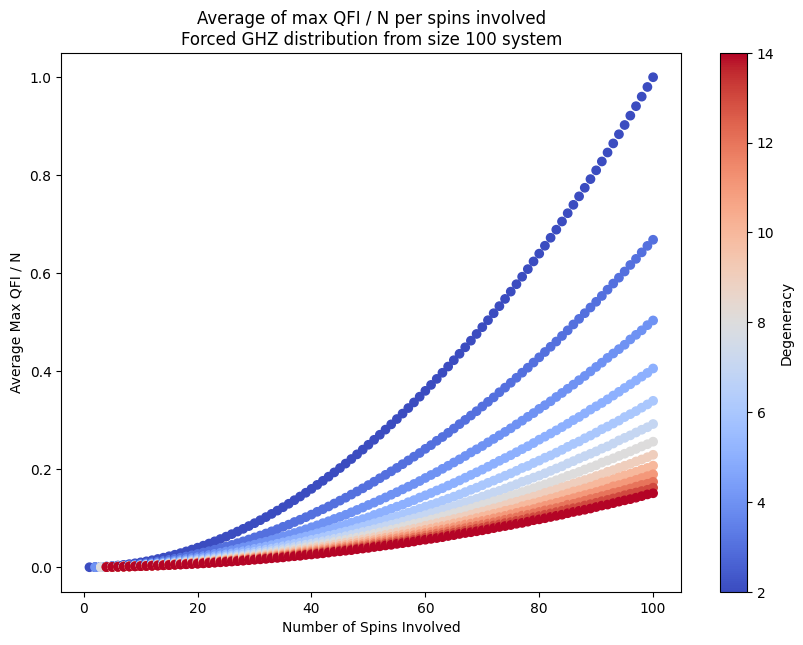

In [4]:
df = pd.DataFrame(data_list_ghz, columns=['si', 'qfi', 'deg'])
plot_df = df.groupby(['si','deg'])['qfi'].mean().reset_index()


cmap = plt.cm.coolwarm
norm = Normalize(vmin=degen_range[0], vmax=degen_range[1] - 1)
plt.figure(figsize=(10,7))
plt.scatter(x=plot_df['si'], y=plot_df['qfi'], c=plot_df["deg"], cmap=cmap, norm=norm)
plt.xlabel("Number of Spins Involved")
plt.ylabel("Average Max QFI / N")
plt.title(f"Average of max QFI / N per spins involved\nForced GHZ distribution from size {N} system")
plt.colorbar(label='Degeneracy')
plt.show()

/var/folders/84/h0vjvdyd5jsfdwfh08421q980000gn/T/ipykernel_96613/2921905587.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby('deg').apply(lambda g: power_law_exp(g))


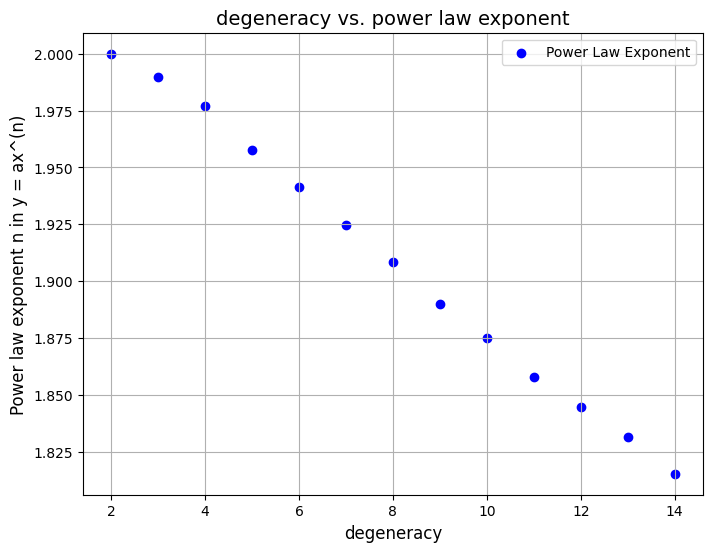

In [5]:
def power_law_exp(group):
    log_x = np.log(group['si'])
    log_y = np.log(group['qfi'])
    slope, _, _, _, _ = linregress(log_x, log_y)
    return slope

# Group by 'deg' and apply the custom aggregation function to groups of 'si' and 'odv'
result = df.groupby('deg').apply(lambda g: power_law_exp(g))

# Plot 'deg' vs. power law expoonent
plt.figure(figsize=(8, 6))
plt.scatter(result.index, result.values, marker='o', color='b', label='Power Law Exponent')
plt.xlabel('degeneracy', fontsize=12)
plt.ylabel('Power law exponent n in y = ax^(n)', fontsize=12)
plt.title('degeneracy vs. power law exponent', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()


In [6]:
N = 100
num_samples = 100
degen_range = [2, 15]
data_list_ghz = []

for degeneracy in range(degen_range[0], degen_range[1]):
    for max_hd in range(int(np.ceil(np.log2(degeneracy))), N + 1):
        for _ in range(num_samples):
            # Generate ground state set
            gs_array = generate_ground_state_set_GHZ(max_hd, degeneracy)

            # Calculate Hamming distances and spins involved
            hd_list, hd_matrix, spins_involved = calculate_hamming_distances(gs_array, degeneracy)

            # Compute overlap distribution and statistics
            _, _, od_var = compute_overlap_distribution(hd_list, N, degeneracy)

            # Append results to the data list
            data_list_ghz.append([spins_involved, od_var, degeneracy])


df_ovd = pd.DataFrame(data_list_ghz, columns=['si', 'odv', 'deg'])


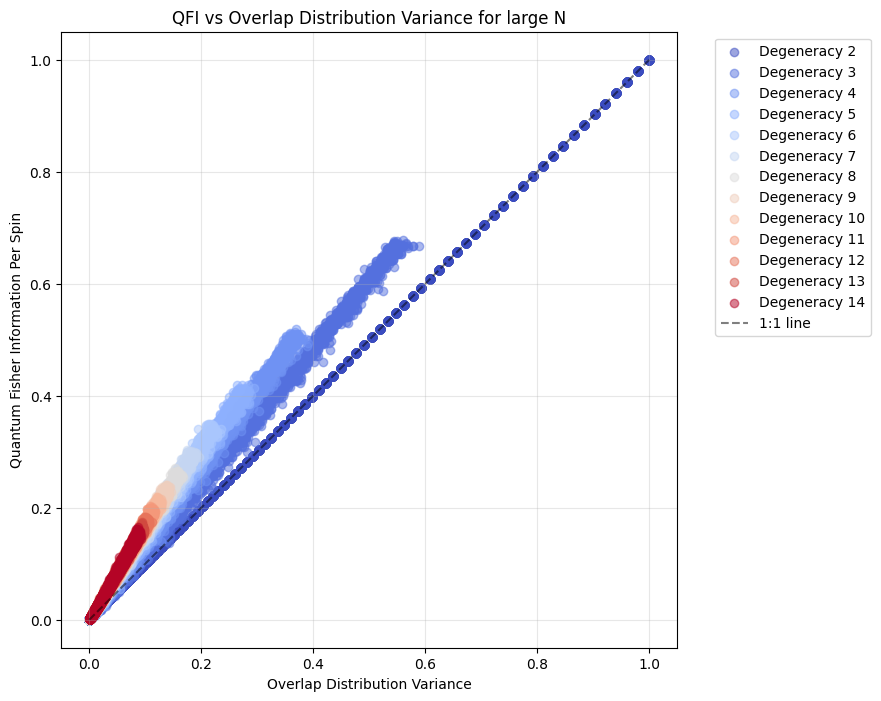

In [19]:
from matplotlib.colors import Normalize

# Create figure with room for colorbar
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Setup colormap
cmap = plt.cm.coolwarm
norm = Normalize(vmin=degen_range[0], vmax=degen_range[1] - 1)

# Create scatter plot for each degeneracy
for deg in df_ovd['deg'].unique():
    mask = df_ovd['deg'] == deg
    plt.scatter(df_ovd[mask]['odv'], 
               df[mask]['qfi'], 
               alpha=0.5,
               color=cmap(norm(deg)),
               label=f'Degeneracy {deg}')

# Add 1:1 line
max_val = max(df_ovd['odv'].max(), df['qfi'].max())
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='1:1 line')

# Add labels and title
plt.xlabel('Overlap Distribution Variance')
plt.ylabel('Quantum Fisher Information Per Spin')
plt.title('QFI vs Overlap Distribution Variance for large N')

# Make axes equal and add grid
plt.axis('square')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add colorbar with

In [12]:
print(df.columns)
print(df.head())

Index(['si', 'qfi', 'deg'], dtype='object')
   si     qfi  deg
0   1  0.0001    2
1   1  0.0001    2
2   1  0.0001    2
3   1  0.0001    2
4   1  0.0001    2


In [28]:
def f(x,y,z):
    return x**2 + y**2 + z**2

f(5,1,1)

27

In [ ]:
# True post annealing ground states - push to 20
# Actual classical ground states up to 100
# Arbitrarily large "artificial ground states"


# Benchmark macroscopic metrics
# domain wall states
# Dicke states